In [49]:
import pandas as pd
import os
import numpy as np
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from collections import Counter
from sklearn.ensemble import IsolationForest
from bokeh.io import output_file, show
from bokeh.plotting import figure

from bokeh.models import ColumnDataSource, FactorRange, Legend, HoverTool, GeoJSONDataSource, \
                        LinearColorMapper, ColorBar, NumeralTickFormatter, Div, Select, TableColumn, \
                        DataTable, CheckboxGroup, Tabs, Panel, CheckboxButtonGroup, RadioButtonGroup
from bokeh.embed import file_html
from bokeh.resources import CDN

from bokeh.io import show, output_notebook, curdoc, output_file
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application
from bokeh.palettes import Category20c, Pastel1, Set3, Blues
from bokeh.layouts import column, row, WidgetBox, gridplot
from bokeh.tile_providers import get_provider, Vendors

from wordcloud import WordCloud
import matplotlib.pyplot as plt
#from bokeh.transform import linear_cmap,factor_cmap

output_notebook()

Loading BokehJS ...

In [50]:
#path = '/Users/Ellen/Documents/Dokumenter/DTU/6.Semester/SocialData/Project/yelp_dataset'
path = 'C:\\Users\\prebe\\Documents\\Ellen\\Python\\Restaurant-Guide-master'
os.chdir(path)
os.getcwd()

'C:\\Users\\prebe\\Documents\\Ellen\\Python\\Restaurant-Guide-master'

In [51]:
df = pd.read_csv('yelp_reviews_RV_categories.csv')

In [52]:
df = df.drop_duplicates(subset='text')
df.shape

(1674264, 19)

In [53]:
#for the smaller dataset
#mask = (df['date'] >= '2019-01-01') & (df['date']<='2021-31-12')
#df = df.loc[mask].reset_index()

In [54]:
#full name of state is inserted
name = []

for state in df['state']:
    if state =='MA':
        name.append('Massachusetts')
    elif state =='FL':
        name.append('Florida')
    elif state =='OR':
        name.append('Oregon')
    elif state =='BC':
        name.append('British Columbia')
    elif state =='GA':
        name.append('Georgia')
    elif state =='TX':
        name.append('Texas')
    elif state =='OH':
        name.append('Ohio')
    elif state =='CO':
        name.append('Colorado')
    elif state =='WA':
        name.append('Washington')
    elif state =='KS':
        name.append('Kansas')
    elif state == 'KY':
        name.append('Kentucky')
        
df['state_name'] = name

In [55]:
N = df.shape[0]
MaxUsed = 100

df = df.iloc[0:N]

In [56]:
#Length of review
df['reviewlength'] = df['text'].str.len()

In [57]:
#number of sentences
df['sentences'] = df["text"].str.count('\.')

In [58]:
#remove stop words
df['filtered_text'] = df.text.apply(remove_stopwords)

In [59]:
# Tokenize the text
df['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in df['filtered_text']] 

In [60]:
#Stem the text
porter_stemmer = PorterStemmer()
df['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in df['tokenized_text']]

In [61]:
df['stemmed_text'] = df['stemmed_tokens'].apply(' '.join)

In [62]:
#count of stars given
min_review = min(df['review_stars'].value_counts())

#dataframes for each star
df1 = df.loc[(df['review_stars'] == 1)]
df2 = df.loc[(df['review_stars'] == 2)]
df3 = df.loc[(df['review_stars'] == 3)]
df4 = df.loc[(df['review_stars'] == 4)]
df5 = df.loc[(df['review_stars'] == 5)]

#sample dataframe for each star
df1 = df1.sample(n=min_review,axis='rows')
df2 = df2.sample(n=min_review,axis='rows')
df3 = df3.sample(n=min_review,axis='rows')
df4 = df4.sample(n=min_review,axis='rows')
df5 = df5.sample(n=min_review,axis='rows')

In [63]:
#balanced reviews
df_word = pd.concat([df1, df2, df3, df4, df5])

In [64]:
Word = []
WordCounter = Counter(" ".join(df_word["stemmed_text"]).split()).most_common(MaxUsed)
for j in range(len(WordCounter)):
    Word.insert(j,WordCounter[j][0])

In [66]:
df = df.reset_index()

In [67]:
Words = np.zeros((N,MaxUsed))

#one-hot encoding over the 100 most used words
for index, row in df.iterrows():
    for i in range(np.size(Words, axis=1)):
        if Word[i] in df['stemmed_text'].iloc[index]:
            Words[index,i] = 1

In [68]:
#drop some attributes with text
df = df.drop(['text','filtered_text','tokenized_text', 'stemmed_tokens'], axis=1)

In [69]:
#dataframe for encoding
df_words = pd.DataFrame(Words)

#Encoding column names are changed
Names = list(range(0, MaxUsed))
ColNames = [str(n) for n in Names]

df_words.columns = ColNames
df_words

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1674259,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1674260,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1674261,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1674262,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [70]:
#The encoding is added to the dataset
df = df.join(df_words)

In [71]:
#label encoding for userID and businessID
df['user_id'] = df['user_id'].astype('category')
df['business_id'] = df['business_id'].astype('category')

df['UserCat'] = df['user_id'].cat.codes
df['BusinessCat'] = df['business_id'].cat.codes

In [72]:
#encode date
df['date']= pd.to_datetime(df['date'])

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
df['DayOfWeek'] = df['date'].dt.dayofweek

In [73]:
df_feature = df[['stars', 'review_count','review_stars','reviewlength', 'sentences', 'UserCat','BusinessCat', 'year', 'month', 'day', 'hour', 'minute', 'DayOfWeek', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99']]

In [74]:
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.2),max_features=1)
model.fit(df_feature)

IsolationForest(contamination=0.2, max_features=1, n_estimators=50)

In [75]:
df['scores']=model.decision_function(df_feature)
df['anomaly']=model.predict(df_feature)

In [76]:
df = df.drop(['reviewlength', 'sentences', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', 'UserCat', 'BusinessCat', 'year', 'month', 'day', 'hour', 'minute', 'DayOfWeek'], axis = 1)

In [77]:
#csv_name = "AnomalyDetection.csv"
#df.to_csv(csv_name, index=False)

In [78]:
csv_name = "AnomalyDetectionSmall.csv"
df.to_csv(csv_name, index=False)

In [79]:
#df = pd.read_csv('AnomalyDetection.csv')
df = pd.read_csv('AnomalyDetectionSmall.csv')

In [94]:
countFake = df['anomaly'].value_counts()
Fake = [countFake[1], countFake[-1]]
#Fake = countFake.to_frame().rename(index={1:'Real review', -1:'Fake review'})

In [100]:
#Plot number of fake/not-fake reviews

pFake = figure(x_range=xFake, plot_width = 800, plot_height=500, toolbar_location=None, title='Anomaly detection')
source = ColumnDataSource(data=dict(x=['Real review', 'Fake review'], y=Fake))
pFake.vbar(x='x', width=0.3, bottom=0, top='y', color='lightblue', source=source)


#hover
pFake.add_tools(HoverTool(tooltips=[('Percentage', "@y")]))

#axis ticks
pFake.y_range.start = 0
pFake.xaxis.major_tick_line_color = None 
pFake.xaxis.minor_tick_line_color = None 
pFake.yaxis.major_tick_line_color = None  
pFake.yaxis.minor_tick_line_color = None  
pFake.y_range.start = 0
pFake.title.text_font_size = '13pt'
pFake.title.align = 'center'

Fake_panel = Panel(child=pFake, title='Anomaly')

show(pFake)

In [82]:
#count of anomaly 
anomalyReviewStars = df.groupby(['anomaly','review_stars'])['review_stars'].count().unstack().fillna(0)
anomalyStars = df.groupby(['anomaly','stars'])['stars'].count().unstack().fillna(0)
anomalyType = df.groupby(['anomaly','cat_type'])["cat_type"].count().unstack().fillna(0)
anomalyKitchen = df.groupby(['anomaly','cat_kitchen'])["cat_kitchen"].count().unstack().fillna(0)
anomalyState = df.groupby(['anomaly','state_name'])['state_name'].count().unstack().fillna(0)

In [83]:
#percent fake reviews - review stars
ReviewStarFake = []
for (colname,colval) in anomalyReviewStars.iteritems():
    ReviewStarFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)

#percent fake reviews - stars
StarFake = []
for (colname,colval) in anomalyStars.iteritems():
    StarFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)

#percent fake reviews - type
TypeFake = []
for (colname,colval) in anomalyType.iteritems():
    TypeFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)
    
#percent fake reviews - kitchen
KitchenFake = []
for (colname,colval) in anomalyKitchen.iteritems():
    KitchenFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)

#percent fake reviews - state
StateFake = []
for (colname,colval) in anomalyState.iteritems():
    StateFake.append(colval.values[0]/(colval.values[0]+colval.values[1])*100)   

In [106]:
#Plot percentage fake reviews within review stars

xReviewStar = df['review_stars'].sort_values(ascending=True).astype(str).unique().tolist()

pReviewStar = figure(x_range=xReviewStar, plot_width = 800, plot_height=500, toolbar_location=None, title='Fake reviews by review stars')
source = ColumnDataSource(data=dict(x=xReviewStar, y=ReviewStarFake))
pReviewStar.vbar(x='x',width=0.7, bottom=0, top='y', color='lightblue', source=source)

#hover
pReviewStar.add_tools(HoverTool(tooltips=[('Percentage', "@y")]))

#axis ticks
pReviewStar.y_range.start = 0
pReviewStar.xaxis.major_tick_line_color = None 
pReviewStar.xaxis.minor_tick_line_color = None 
pReviewStar.yaxis.major_tick_line_color = None  
pReviewStar.yaxis.minor_tick_line_color = None  
pReviewStar.y_range.start = 0
pReviewStar.title.text_font_size = '13pt'
pReviewStar.title.align = 'center'

ReviewStar_panel = Panel(child=pReviewStar, title='Review Stars')

In [115]:
#Plot percentage fake reviews within stars

xStar = df['stars'].sort_values(ascending=True).astype(str).unique().tolist()

pStar = figure(x_range=xStar, plot_width = 800, plot_height=500, toolbar_location=None, title='Fake reviews by stars')
source = ColumnDataSource(data=dict(x=xStar, y=StarFake))
pStar.vbar(x='x',width=0.7, bottom=0, top='y', color='lightblue', source=source)

#hover
pStar.add_tools(HoverTool(tooltips=[('Percentage', "@y")]))

#axis ticks
pStar.y_range.start = 0
pStar.xaxis.major_tick_line_color = None 
pStar.xaxis.minor_tick_line_color = None 
pStar.yaxis.major_tick_line_color = None  
pStar.yaxis.minor_tick_line_color = None  
pStar.y_range.start = 0
pStar.title.text_font_size = '13pt'
pStar.title.align = 'center'

Star_panel = Panel(child=pStar, title='Stars')

In [116]:
#Plot percentage fake reviews within type of restaurant

#output_file("bars.html")
xType = df['cat_type'].sort_values(ascending=True).unique().tolist()

pType = figure(x_range=xType, plot_width = 800, plot_height=500, toolbar_location=None, title='Fake reviews by type of restaurant')
source = ColumnDataSource(data=dict(x=xType, y=TypeFake))
pType.vbar(x='x',width=0.7, bottom=0, top='y', color='lightblue', source=source)

#hover
pType.add_tools(HoverTool(tooltips=[('Percentage', "@y")]))

#axis ticks
pType.y_range.start = 0
pType.xaxis.major_tick_line_color = None 
pType.xaxis.minor_tick_line_color = None 
pType.yaxis.major_tick_line_color = None  
pType.yaxis.minor_tick_line_color = None  
pType.y_range.start = 0
pType.xaxis.major_label_orientation = "vertical"
pType.title.text_font_size = '13pt'
pType.title.align = 'center'

Type_panel = Panel(child=pType, title='Type of restaurant')


In [117]:
#Plot percentage fake reviews within type of kitchen

xKitchen = df['cat_kitchen'].sort_values(ascending=True).unique().tolist()

pKitchen = figure(x_range=xKitchen, plot_width = 800, plot_height=500, toolbar_location=None, title='Fake reviews by type of kitchen')
source = ColumnDataSource(data=dict(x=xKitchen, y=KitchenFake))
pKitchen.vbar(x='x',width=0.7, bottom=0, top='y', color='lightblue', source=source)

#hover
pKitchen.add_tools(HoverTool(tooltips=[('Percentage', "@y")]))

#axis ticks
pKitchen.xaxis.major_tick_line_color = None 
pKitchen.xaxis.minor_tick_line_color = None 
pKitchen.yaxis.major_tick_line_color = None  
pKitchen.yaxis.minor_tick_line_color = None  
pKitchen.y_range.start = 0
pKitchen.xaxis.major_label_orientation = "vertical"
pKitchen.title.text_font_size = '13pt'
pKitchen.title.align = 'center'

Kitchen_panel = Panel(child=pKitchen, title='Type of kitchen')


In [118]:
#Plot percentage fake reviews within state

xState = df['state_name'].sort_values(ascending=True).unique().tolist()

pState = figure(x_range=xState, plot_width = 800, plot_height=500, toolbar_location=None, title='Fake reviews by state')
source = ColumnDataSource(data=dict(x=xState, y=StateFake))
pState.vbar(x='x',width=0.7, bottom=0, top='y', color='lightblue', source=source)

#hover
pState.add_tools(HoverTool(tooltips=[('Percentage', "@y")]))

#axis ticks
pState.xaxis.major_tick_line_color = None 
pState.xaxis.minor_tick_line_color = None 
pState.yaxis.major_tick_line_color = None  
pState.yaxis.minor_tick_line_color = None  
pState.y_range.start = 0
pState.xaxis.major_label_orientation = "vertical"
pState.title.text_font_size = '13pt'
pState.title.align = 'center'

State_panel = Panel(child=pState, title='State')


In [119]:
tabs = Tabs(tabs=[ReviewStar_panel, Star_panel, Type_panel, Kitchen_panel, State_panel])

show(tabs)

In [120]:
html = file_html(tabs, CDN, "test")
print(html)





<!DOCTYPE html>
<html lang="en">
  
  <head>
    
      <meta charset="utf-8">
      <title>test</title>
      
      
        
          
        
        
          
        <script type="text/javascript" src="https://cdn.bokeh.org/bokeh/release/bokeh-2.3.2.min.js" integrity="sha384-XypntL49z55iwGVUW4qsEu83zKL3XEcz0MjuGOQ9SlaaQ68X/g+k1FcioZi7oQAc" crossorigin="anonymous"></script>
        <script type="text/javascript">
            Bokeh.set_log_level("info");
        </script>
        
      
      
    
  </head>
  
  
  <body>
    
      
        
          
          
            
              <div class="bk-root" id="ed28685d-9367-4bc9-8bf7-5b046217a723" data-root-id="7663"></div>
            
          
        
      
      
        <script type="application/json" id="8838">
          {"abce1517-8535-43e5-980d-7d5f2c1336b7":{"defs":[],"roots":{"references":[{"attributes":{"tabs":[{"id":"5190"},{"id":"7539"},{"id":"7580"},{"id":"7621"},{"id":"7662"}]},"id":"7663","type":"T

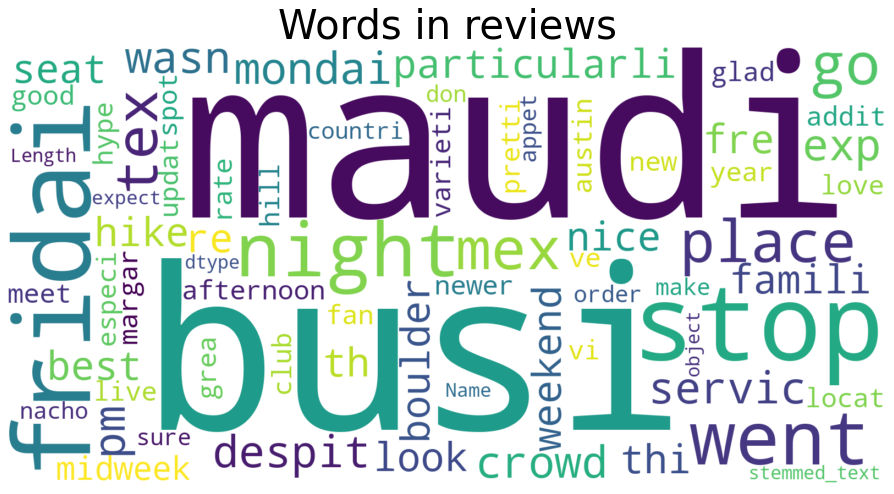

In [121]:
wc = WordCloud(width=1600, height=800, random_state=42, max_words=1000000, background_color = 'white')

# generation
wc.generate(str(df['stemmed_text']))

plt.figure(figsize=(15,10), facecolor='white')
plt.title("Words in reviews", fontsize=40, color='black')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)


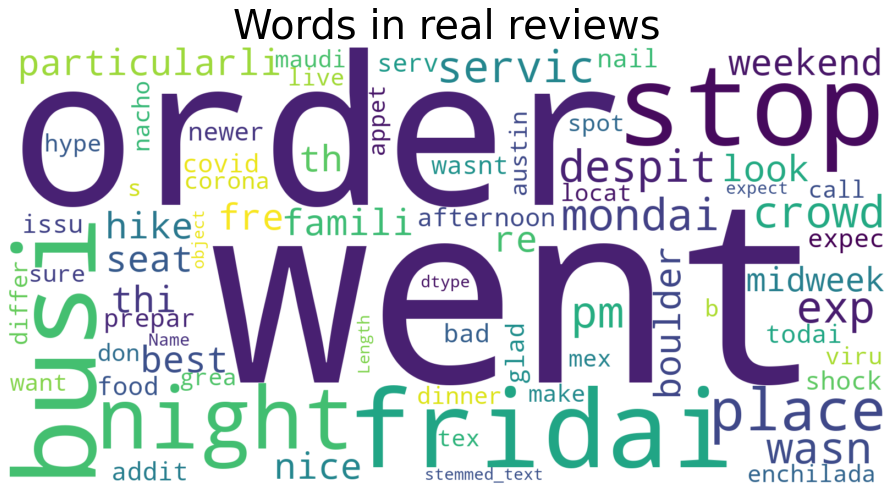

In [122]:
wc = WordCloud(width=1600, height=800, random_state=42, max_words=1000000, background_color = 'white')

# generation
wc.generate(str(df[df['anomaly'] ==1]['stemmed_text']))

plt.figure(figsize=(15,10), facecolor='white')
plt.title("Words in real reviews", fontsize=40, color='black')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)

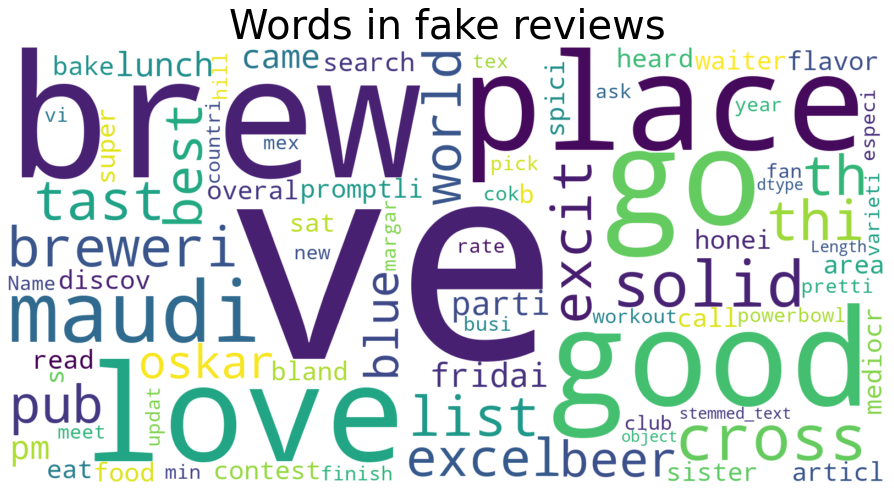

In [123]:
wc = WordCloud(width=1600, height=800, random_state=42, max_words=1000000, background_color = 'white')

# generation
wc.generate(str(df[df['anomaly'] ==-1]['stemmed_text']))

plt.figure(figsize=(15,10), facecolor='white')
plt.title("Words in fake reviews", fontsize=40, color='black')
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=10)


